### Introduction

### Import Packages

In [2]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyod-1.0.6.tar.gz (141 kB)
  Created wheel for pyod: filename=pyod-1.0.6-py3-none-any.whl size=175098 sha256=f4c46e279071f3fa854b1cd3f5353bbbee018a27265b53671c647b5b164b69da
  Stored in directory: /root/.cache/pip/wheels/98/93/e6/6d40410d9635ecde42d06041a1ba7f2ee7396e036fcf702e73
Successfully built pyod


In [3]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import pyod
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# benchmark files checking
all_files=[]
for root, dirs, files in os.walk("/content/drive/MyDrive/SKAB-master/data"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [6]:
all_files

['/content/drive/MyDrive/SKAB-master/data/valve2/0.csv',
 '/content/drive/MyDrive/SKAB-master/data/valve2/3.csv',
 '/content/drive/MyDrive/SKAB-master/data/valve2/1.csv',
 '/content/drive/MyDrive/SKAB-master/data/valve2/2.csv',
 '/content/drive/MyDrive/SKAB-master/data/anomaly-free/anomaly-free.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/11.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/3.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/6.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/2.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/12.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/8.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/10.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/1.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/9.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/13.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/4.csv',
 '/content/drive/MyDrive/SKAB-master/data/other/7.csv',
 '/content/drive/MyDri

In [7]:
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [8]:
anomaly_free_df

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000
...,...,...,...,...,...,...,...,...
2020-02-08 16:16:43,0.225744,0.267921,2.91598,0.054711,88.8593,29.3792,219.542,126.000
2020-02-08 16:16:44,0.205870,0.258370,1.71505,0.710565,89.1754,29.3692,221.862,126.000
2020-02-08 16:16:45,0.219222,0.267244,2.35834,-0.273216,89.1306,29.3674,226.050,126.679


In [9]:
#loading anomalous data
anomalous_data = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

### Data description & Visualization

In [10]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(anomalous_data)}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in anomalous_data])
n_outlier = sum([len(df[df.anomaly==1.]) for df in anomalous_data])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the dataset:')
display(anomalous_data[0].head())

A number of datasets in the SkAB v1.0: 34

A number of changepoints in the SkAB v1.0: 129

A number of outliers in the SkAB v1.0: 13067

Head of the dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 15:56:30,0.027608,0.039203,1.290480,0.054711,68.6194,24.3670,241.062,32.0362,0.0,0.0
2020-03-09 15:56:31,0.027166,0.039940,1.285650,0.382638,68.5923,24.3660,238.709,32.9649,0.0,0.0
2020-03-09 15:56:32,0.027718,0.040167,1.155880,0.054711,68.5207,24.3666,226.485,32.0362,0.0,0.0
2020-03-09 15:56:33,0.028045,0.038026,0.971268,0.382638,68.5425,24.3634,220.378,32.9649,0.0,0.0
2020-03-09 15:56:34,0.027644,0.038580,1.072460,-0.273216,68.6569,24.3639,233.922,32.0000,0.0,0.0


### Isolation Forest

In [11]:
# classifier initializing
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0, 
                      n_jobs=-1,
                      contamination=0.01)

In [12]:
# inference
predicted_outlier, predicted_cp = [], []
for df in anomalous_data:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # classifier fitting
    clf.fit(X_train)

    # results predicting
    prediction = pd.Series(clf.predict(df.drop(['anomaly','changepoint'], axis=1))*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

In [13]:
X_train = anomalous_data[0].drop(['anomaly','changepoint'], axis=1)

In [14]:
X_train

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-03-09 15:56:30,0.027608,0.039203,1.290480,0.054711,68.6194,24.3670,241.062,32.0362
2020-03-09 15:56:31,0.027166,0.039940,1.285650,0.382638,68.5923,24.3660,238.709,32.9649
2020-03-09 15:56:32,0.027718,0.040167,1.155880,0.054711,68.5207,24.3666,226.485,32.0362
2020-03-09 15:56:33,0.028045,0.038026,0.971268,0.382638,68.5425,24.3634,220.378,32.9649
2020-03-09 15:56:34,0.027644,0.038580,1.072460,-0.273216,68.6569,24.3639,233.922,32.0000
...,...,...,...,...,...,...,...,...
2020-03-09 16:16:25,0.027446,0.039528,0.678398,0.382638,67.7144,24.3205,253.086,32.0000
2020-03-09 16:16:26,0.028101,0.038690,0.858077,0.382638,67.7998,24.3226,234.633,32.0384
2020-03-09 16:16:27,0.028037,0.039878,0.567099,0.054711,67.6625,24.3225,224.864,32.9627


In [15]:
clf.fit(X_train[:400])

IsolationForest(contamination=0.01, n_jobs=-1, random_state=0)

In [16]:
prediction = pd.Series(clf.predict(anomalous_data[0].drop(['anomaly','changepoint'], axis=1))*-1, 
                                index=anomalous_data[0].index).rolling(3).median().fillna(0).replace(-1,0)

In [17]:
prediction

datetime
2020-03-09 15:56:30    0.0
2020-03-09 15:56:31    0.0
2020-03-09 15:56:32    0.0
2020-03-09 15:56:33    0.0
2020-03-09 15:56:34    0.0
                      ... 
2020-03-09 16:16:25    1.0
2020-03-09 16:16:26    1.0
2020-03-09 16:16:27    1.0
2020-03-09 16:16:28    1.0
2020-03-09 16:16:29    0.0
Length: 1125, dtype: float64

In [18]:
prediction_cp = abs(prediction.diff())
prediction_cp[0] = prediction[0]

In [19]:
sum(prediction)

278.0

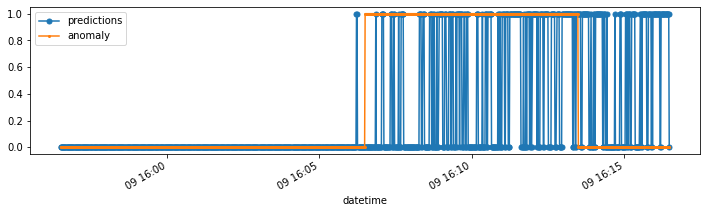

In [20]:
prediction.plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
anomalous_data[0].anomaly.plot(marker='o', markersize=2)
plt.legend();

In [21]:
from sklearn.metrics import classification_report,accuracy_score
print(accuracy_score(anomalous_data[0].anomaly,prediction))
print("Classification Report :")
print(classification_report(anomalous_data[0].anomaly,prediction))

0.7173333333333334
Classification Report :
              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       731
         1.0       0.64      0.45      0.53       394

    accuracy                           0.72      1125
   macro avg       0.69      0.66      0.66      1125
weighted avg       0.71      0.72      0.70      1125



In [22]:
def evaluating_change_point(true, prediction, metric='binary', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true, prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
          true_ = true == 1 
          prediction_ = prediction == 1
          TP = (true_ & prediction_).sum()
          TN = (~true_ & ~prediction_).sum()
          FP = (~true_ & prediction_).sum()
          FN = (true_ & ~prediction_).sum()
          return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1
    return binary(true, prediction)

In [23]:
true_outlier = [df.anomaly for df in anomalous_data]

In [24]:
binary = evaluating_change_point(true_outlier,predicted_outlier, metric='binary')

False Alarm Rate 4.4 %
Missing Alarm Rate 63.54 %
F1 metric 0.5


### PyOD

In [26]:
!pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD

In [28]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.10

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state),
    'KDE': KDE(contamination=outliers_fraction),
}

In [30]:
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Principal Component Analysis (PCA)
Model 12 Locally Selective Combination (LSCP)
Model 13 KDE


In [29]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
  predicted_outlier = []
  print(i + 1, 'fitting', clf_name)
  for df in anomalous_data:
    X_train = df.drop(['anomaly','changepoint'], axis=1)
    
    # classifier fitting
    clf.fit(X_train[:400])

    # results predicting
    prediction = pd.Series(clf.predict(df.drop(['anomaly','changepoint'], axis=1)),index=df.index)
    # predicted outliers saving
    predicted_outlier.append(prediction)
  print("-"*10, clf_name, "results", "-"*10)
  evaluating_change_point(true_outlier,predicted_outlier, metric='binary')

1 fitting Angle-based Outlier Detector (ABOD)
---------- Angle-based Outlier Detector (ABOD) results ----------
False Alarm Rate 22.94 %
Missing Alarm Rate 21.01 %
F1 metric 0.71
2 fitting Cluster-based Local Outlier Factor (CBLOF)
---------- Cluster-based Local Outlier Factor (CBLOF) results ----------
False Alarm Rate 14.42 %
Missing Alarm Rate 50.15 %
F1 metric 0.56
3 fitting Feature Bagging
---------- Feature Bagging results ----------
False Alarm Rate 21.8 %
Missing Alarm Rate 23.12 %
F1 metric 0.71
4 fitting Histogram-base Outlier Detection (HBOS)
---------- Histogram-base Outlier Detection (HBOS) results ----------
False Alarm Rate 28.16 %
Missing Alarm Rate 18.7 %
F1 metric 0.7
5 fitting Isolation Forest
---------- Isolation Forest results ----------
False Alarm Rate 27.18 %
Missing Alarm Rate 20.71 %
F1 metric 0.69
6 fitting K Nearest Neighbors (KNN)
---------- K Nearest Neighbors (KNN) results ----------
False Alarm Rate 18.19 %
Missing Alarm Rate 30.21 %
F1 metric 0.69
7 fit